In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)


Tensorflow 2.2.0


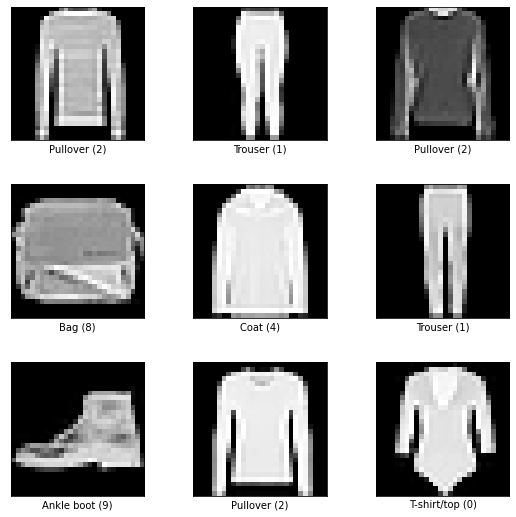

In [2]:

ds_train, ds_info = tfds.load('fashion_mnist', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_info, ds_train)


In [3]:
batch_size = 128
image_shape = (32, 32, 1)

def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])    
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    return image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size, drop_remainder=True).repeat()

train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

469


In [8]:
class WGAN_GP():
    def __init__(self, input_shape):

        self.z_dim = 128
        self.input_shape = input_shape

        # critic
        self.n_critic = 5
        self.penalty_const = 10
        self.critic = self.build_critic()
        self.critic.trainable = False

        self.optimizer_critic = Adam(1e-4, 0.5, 0.9)

        # build generator pipeline with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss = self.wasserstein_loss,
                           optimizer = Adam(1e-4, 0.5, 0.9))

        
    def wasserstein_loss(self, y_true, y_pred):

        w_loss = -tf.reduce_mean(y_true*y_pred)

        return w_loss

    def build_generator(self):

        DIM=128
        model = tf.keras.Sequential(name='Generator') 

        model.add(layers.Input(shape=[self.z_dim])) 

        model.add(layers.Dense(4*4*4*DIM))
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())
        model.add(layers.Reshape((4,4,4*DIM))) 

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(2*DIM, 5, padding='same')) 
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(DIM, 5, padding='same')) 
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))       
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh')) 

        return model             
    
    def build_critic(self):

        DIM = 128
        model = tf.keras.Sequential(name='critics') 

        model.add(layers.Input(shape=self.input_shape)) 

        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))


        model.add(layers.Flatten()) 
        model.add(layers.Dense(1)) 

        return model     
    
 
    def gradient_loss(self, grad):

        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1,len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        loss = self.penalty_const * loss
        return loss

    def train_critic(self, real_images, batch_size):
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
                  
        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = self.generator.predict(g_input)
        
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)
            
            # calculate losses
            loss_fake = self.wasserstein_loss(fake_labels, pred_fake)
            loss_real = self.wasserstein_loss(real_labels, pred_real)           
            
            # gradient penalty      
            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            
            critic_interpolates = self.critic(interpolates)
            gradients_interpolates = gradient_tape.gradient(critic_interpolates, [interpolates])
            gradient_penalty = self.gradient_loss(gradients_interpolates)
     
            # total loss
            total_loss = loss_fake + loss_real + gradient_penalty
            
            # apply gradients
            gradients = total_tape.gradient(total_loss, self.critic.variables)
            
            self.optimizer_critic.apply_gradients(zip(gradients, self.critic.variables))

        return loss_fake, loss_real, gradient_penalty
                                                
    def train(self, data_generator, batch_size, steps, interval=100):

        val_g_input = tf.random.normal((batch_size, self.z_dim))
        real_labels = tf.ones(batch_size)

        for i in range(steps):
            for _ in range(self.n_critic):
                real_images = next(data_generator)
                loss_fake, loss_real, gradient_penalty = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real + gradient_penalty
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)
            if i%interval == 0:
                msg = "Step {}: g_loss {:.4f} critic_loss {:.4f} critic fake {:.4f}  critic_real {:.4f} penalty {:.4f}"\
                .format(i, g_loss, critic_loss, loss_fake, loss_real, gradient_penalty)
                print(msg)

                fake_images = self.generator.predict(val_g_input)
                self.plot_images(fake_images)

    def plot_images(self, images):   
        grid_row = 1
        grid_col = 8
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2.5, grid_row*2.5))
        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1]==1:
                    axarr[col].imshow(images[col,:,:,0]*0.5+0.5, cmap='gray')
                else:
                    axarr[col].imshow(images[col]*0.5+0.5)
                axarr[col].axis('off') 
        plt.show()

    

Step 0: g_loss -0.2171 critic_loss -0.2074 critic fake 0.0047  critic_real -0.2543 penalty 0.0422


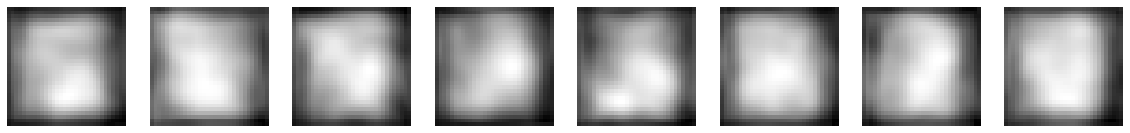

Step 100: g_loss -3.9911 critic_loss -1.9957 critic fake -1.4203  critic_real -0.5798 penalty 0.0045


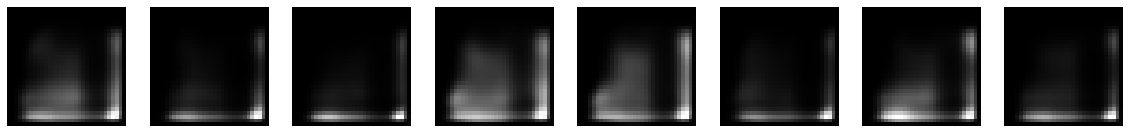

Step 200: g_loss -1.4046 critic_loss -3.2638 critic fake -2.2477  critic_real -1.6176 penalty 0.6015


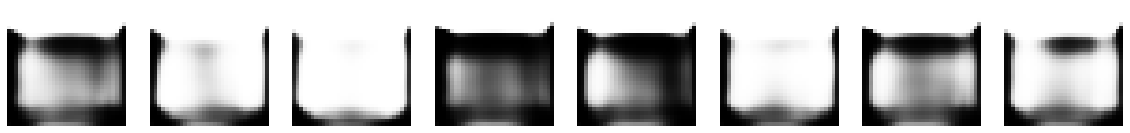

Step 300: g_loss -1.4551 critic_loss -1.6034 critic fake -0.7482  critic_real -0.8556 penalty 0.0004


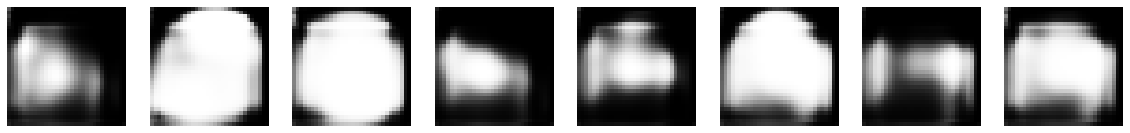

Step 400: g_loss 0.6292 critic_loss -1.1434 critic fake -0.4965  critic_real -0.7023 penalty 0.0555


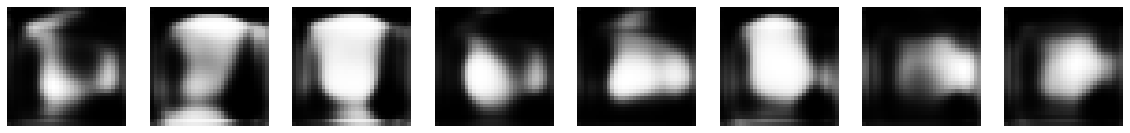

Step 500: g_loss 0.3254 critic_loss -1.0430 critic fake -0.3425  critic_real -0.8543 penalty 0.1538


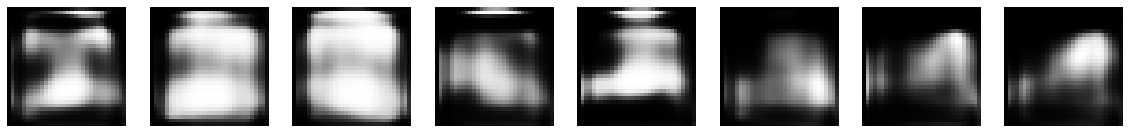

Step 600: g_loss 0.7257 critic_loss -1.4599 critic fake -1.1366  critic_real -0.4024 penalty 0.0791


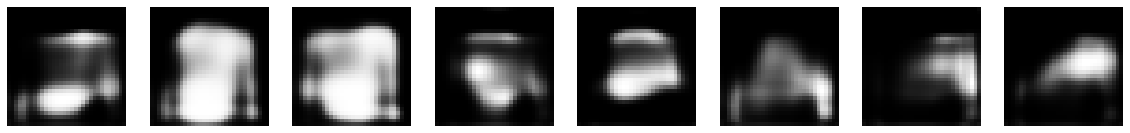

Step 700: g_loss -0.0339 critic_loss -0.7489 critic fake -0.0655  critic_real -0.6846 penalty 0.0012


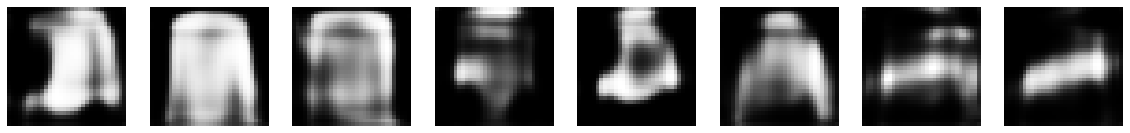

Step 800: g_loss -0.0622 critic_loss -0.5405 critic fake 0.0346  critic_real -0.5959 penalty 0.0208


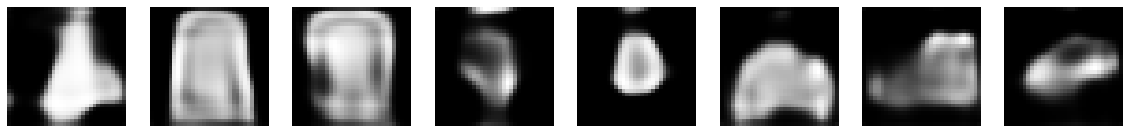

Step 900: g_loss -0.1042 critic_loss -0.4570 critic fake -0.0625  critic_real -0.4162 penalty 0.0217


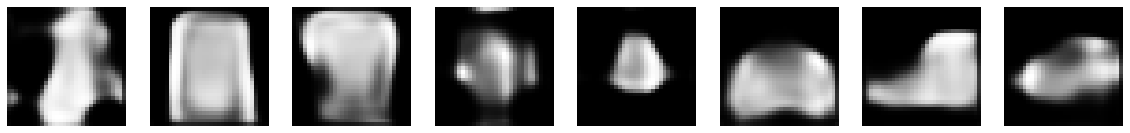

Step 1000: g_loss 0.0079 critic_loss -0.4517 critic fake -0.0419  critic_real -0.4103 penalty 0.0004


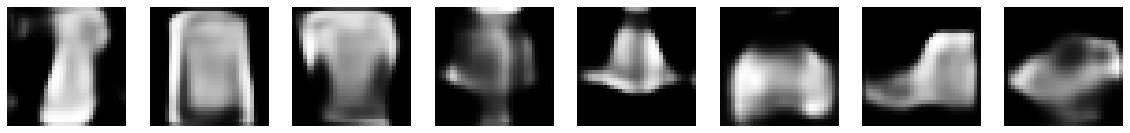

Step 1100: g_loss 0.0589 critic_loss -0.4135 critic fake -0.1315  critic_real -0.2874 penalty 0.0054


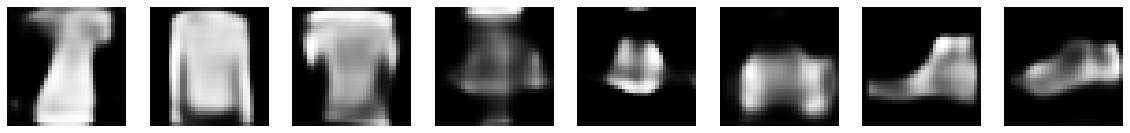

Step 1200: g_loss 0.2043 critic_loss -0.4508 critic fake -0.2215  critic_real -0.2293 penalty 0.0000


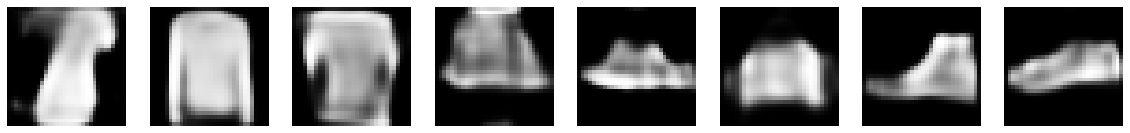

Step 1300: g_loss -0.0289 critic_loss -0.3631 critic fake 0.0405  critic_real -0.4686 penalty 0.0650


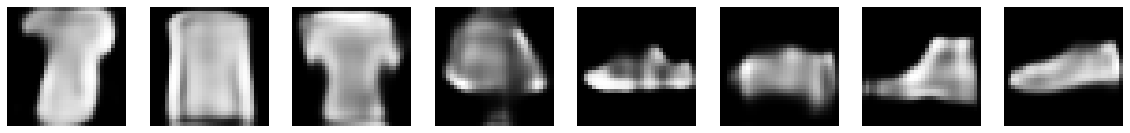

Step 1400: g_loss 0.3237 critic_loss -0.3777 critic fake -0.3290  critic_real -0.0488 penalty 0.0001


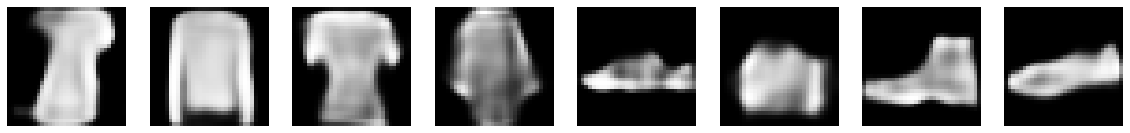

Step 1500: g_loss -0.0626 critic_loss -0.4184 critic fake 0.0056  critic_real -0.4253 penalty 0.0013


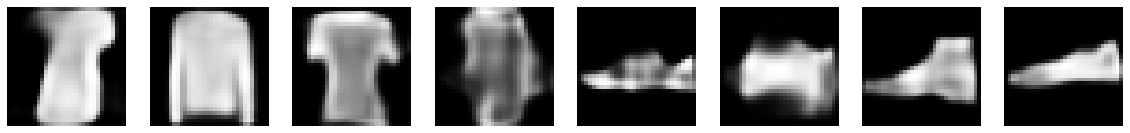

Step 1600: g_loss -0.3152 critic_loss -0.3813 critic fake 0.3163  critic_real -0.7068 penalty 0.0092


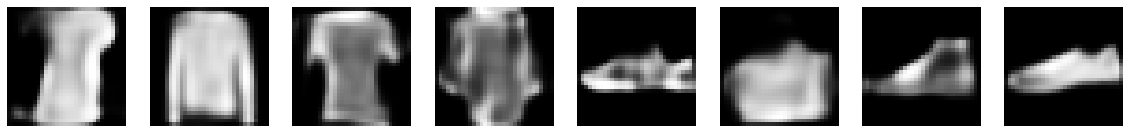

Step 1700: g_loss 0.0881 critic_loss -0.4283 critic fake -0.1791  critic_real -0.2542 penalty 0.0050


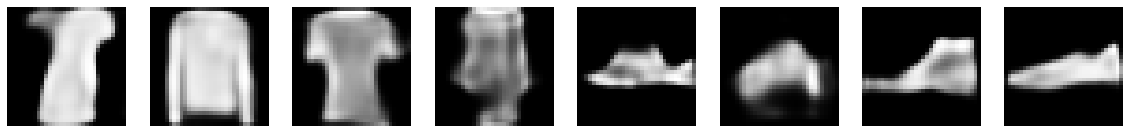

Step 1800: g_loss 0.0401 critic_loss -0.3754 critic fake -0.0920  critic_real -0.2863 penalty 0.0029


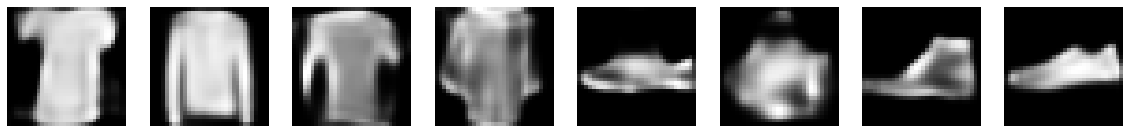

Step 1900: g_loss -0.0301 critic_loss -0.3413 critic fake 0.0436  critic_real -0.3887 penalty 0.0038


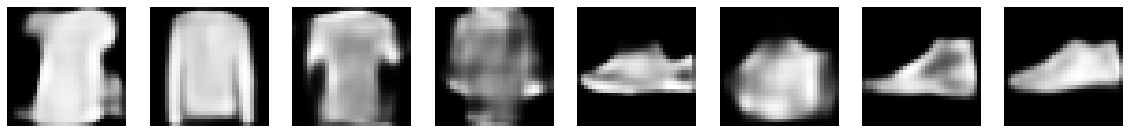

Step 2000: g_loss 0.0488 critic_loss -0.3150 critic fake -0.0236  critic_real -0.3611 penalty 0.0698


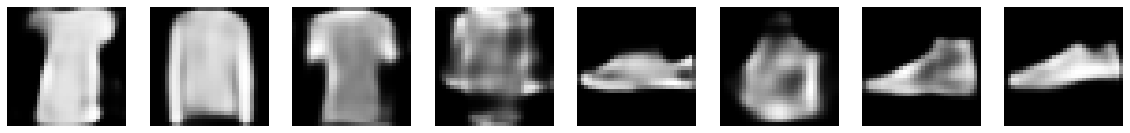

Step 2100: g_loss -0.0481 critic_loss -0.3342 critic fake 0.0762  critic_real -0.4343 penalty 0.0240


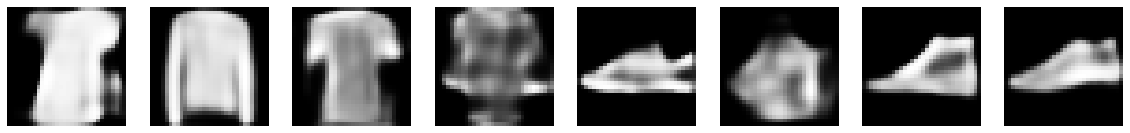

Step 2200: g_loss 0.0833 critic_loss -0.3346 critic fake -0.0874  critic_real -0.2573 penalty 0.0100


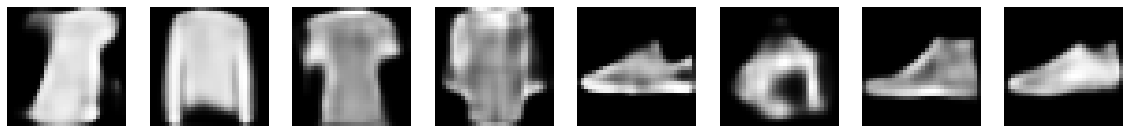

Step 2300: g_loss 0.1410 critic_loss -0.2753 critic fake -0.1423  critic_real -0.1382 penalty 0.0052


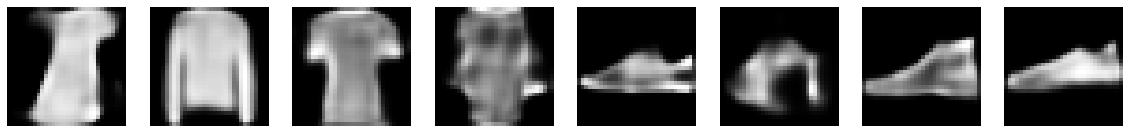

Step 2400: g_loss -0.2514 critic_loss -0.3143 critic fake 0.2332  critic_real -0.5692 penalty 0.0217


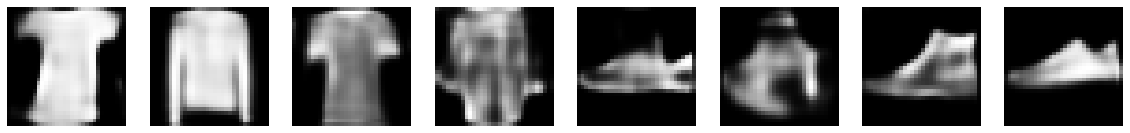

Step 2500: g_loss 0.0034 critic_loss -0.2724 critic fake 0.0368  critic_real -0.3328 penalty 0.0235


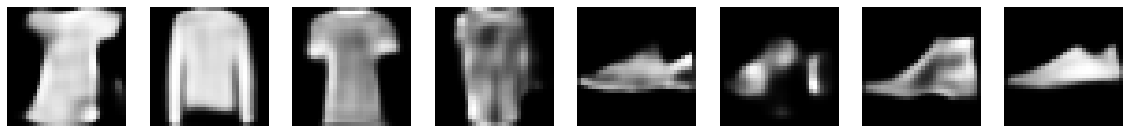

Step 2600: g_loss -0.1110 critic_loss -0.2947 critic fake 0.1116  critic_real -0.4191 penalty 0.0129


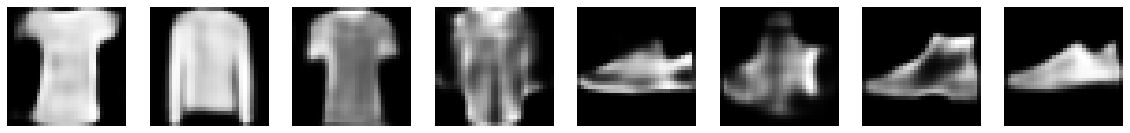

Step 2700: g_loss 0.0057 critic_loss -0.3420 critic fake -0.0221  critic_real -0.3199 penalty 0.0000


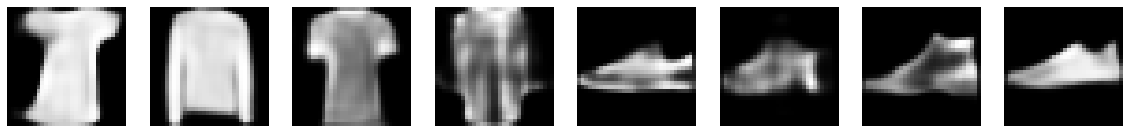

Step 2800: g_loss 0.0189 critic_loss -0.2876 critic fake -0.0331  critic_real -0.2652 penalty 0.0106


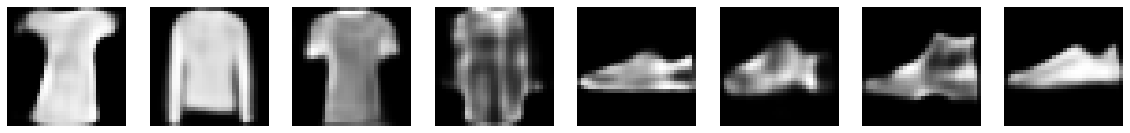

Step 2900: g_loss 0.1316 critic_loss -0.3141 critic fake -0.1197  critic_real -0.1945 penalty 0.0000


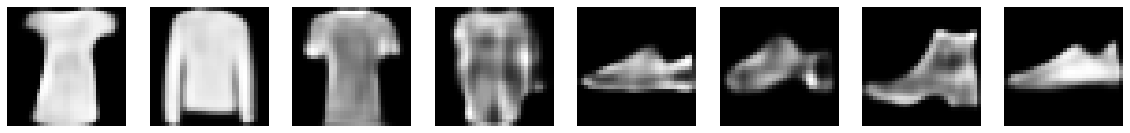

Step 3000: g_loss 0.0298 critic_loss -0.2338 critic fake 0.0162  critic_real -0.2766 penalty 0.0267


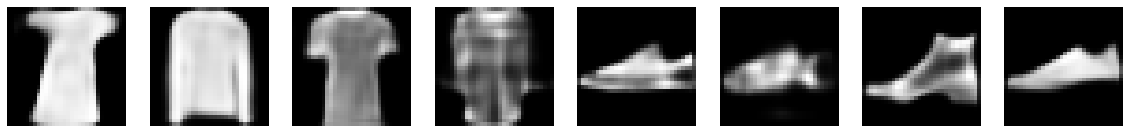

Step 3100: g_loss -0.0595 critic_loss -0.2767 critic fake 0.0404  critic_real -0.3882 penalty 0.0710


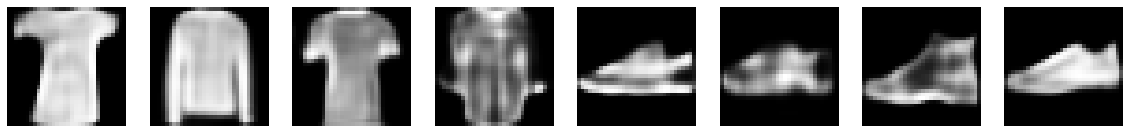

Step 3200: g_loss 0.0231 critic_loss -0.2951 critic fake -0.0440  critic_real -0.2528 penalty 0.0017


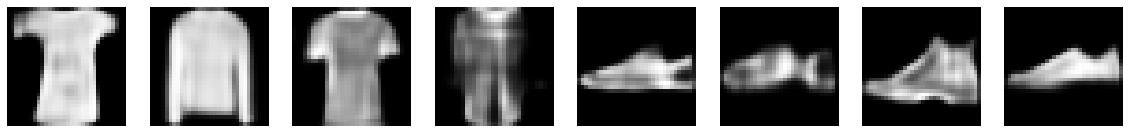

Step 3300: g_loss 0.0954 critic_loss -0.3431 critic fake -0.0930  critic_real -0.2641 penalty 0.0140


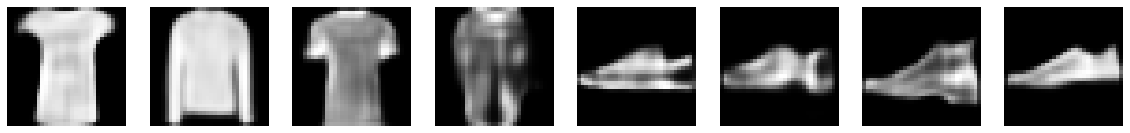

Step 3400: g_loss 0.0696 critic_loss -0.2806 critic fake -0.0326  critic_real -0.2492 penalty 0.0012


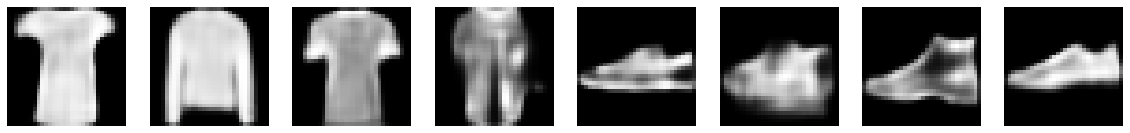

Step 3500: g_loss -0.0782 critic_loss -0.2850 critic fake 0.0477  critic_real -0.3380 penalty 0.0053


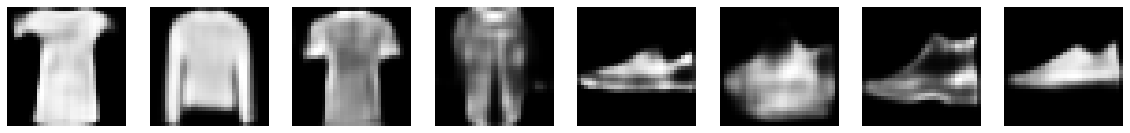

Step 3600: g_loss 0.0582 critic_loss -0.2826 critic fake -0.0287  critic_real -0.2543 penalty 0.0005


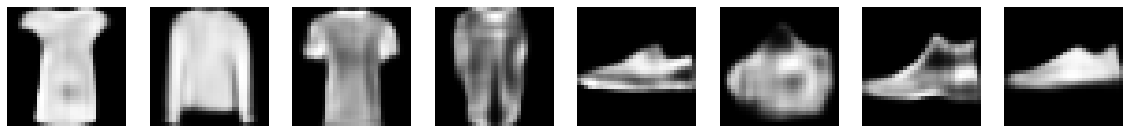

Step 3700: g_loss -0.0444 critic_loss -0.2563 critic fake 0.0741  critic_real -0.3304 penalty 0.0000


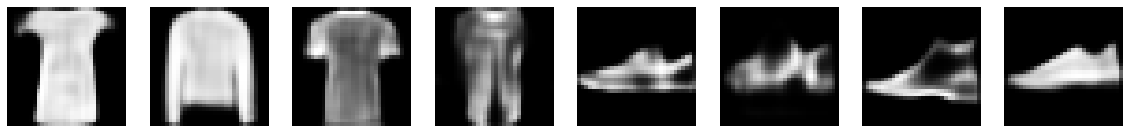

Step 3800: g_loss -0.0526 critic_loss -0.2141 critic fake 0.0852  critic_real -0.3158 penalty 0.0165


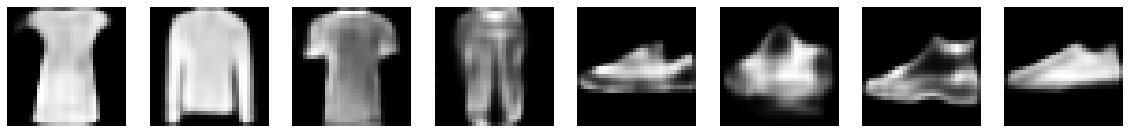

Step 3900: g_loss -0.0901 critic_loss -0.2563 critic fake 0.1177  critic_real -0.3807 penalty 0.0068


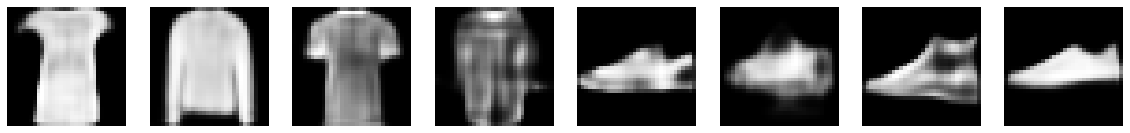

Step 4000: g_loss -0.1815 critic_loss -0.2639 critic fake 0.1426  critic_real -0.4065 penalty 0.0000


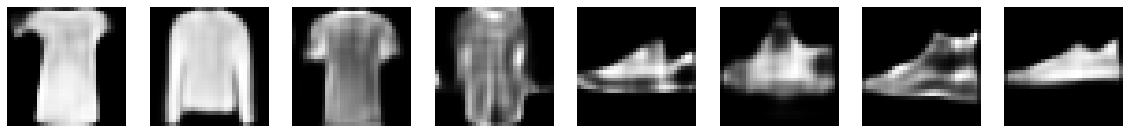

Step 4100: g_loss -0.1520 critic_loss -0.2402 critic fake 0.1557  critic_real -0.4051 penalty 0.0092


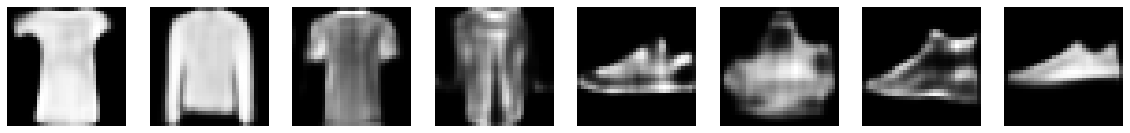

Step 4200: g_loss -0.0754 critic_loss -0.2650 critic fake 0.0515  critic_real -0.3260 penalty 0.0095


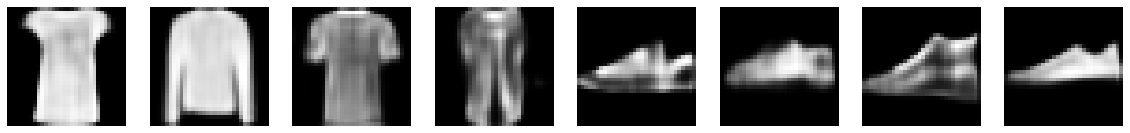

Step 4300: g_loss -0.1160 critic_loss -0.2425 critic fake 0.0980  critic_real -0.3434 penalty 0.0029


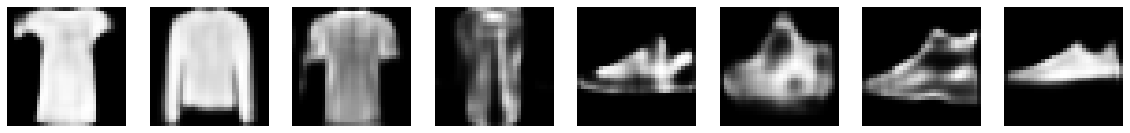

Step 4400: g_loss -0.0671 critic_loss -0.2159 critic fake 0.0838  critic_real -0.3052 penalty 0.0056


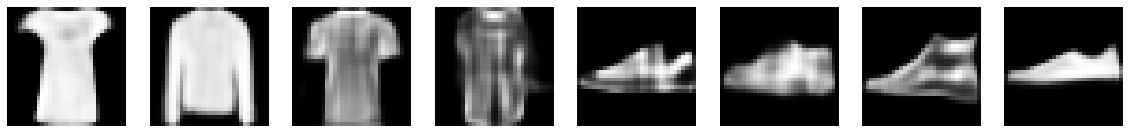

Step 4500: g_loss -0.1544 critic_loss -0.2396 critic fake 0.1164  critic_real -0.3560 penalty 0.0000


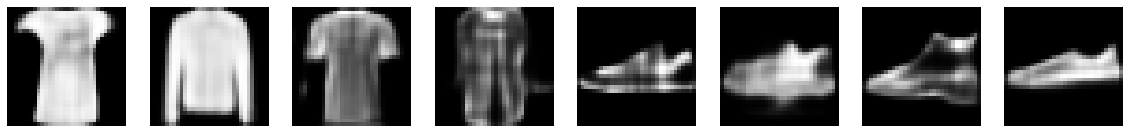

Step 4600: g_loss 0.1487 critic_loss -0.2916 critic fake -0.1554  critic_real -0.1473 penalty 0.0111


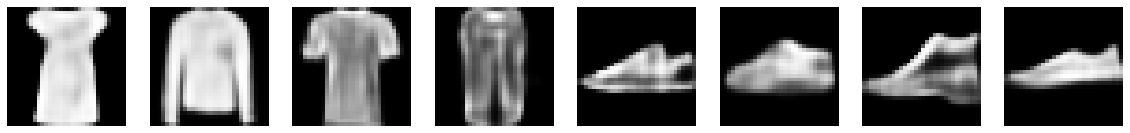

Step 4700: g_loss -0.0978 critic_loss -0.2338 critic fake 0.0833  critic_real -0.3192 penalty 0.0021


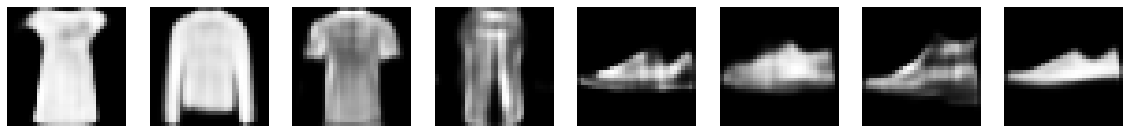

Step 4800: g_loss 0.0231 critic_loss -0.2310 critic fake -0.0669  critic_real -0.1703 penalty 0.0061


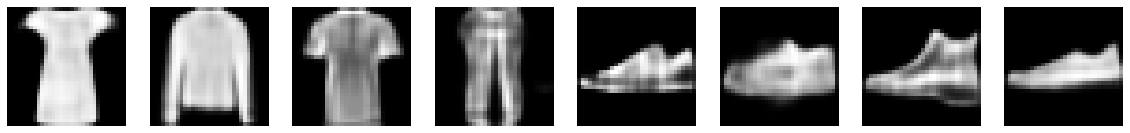

Step 4900: g_loss -0.0593 critic_loss -0.2310 critic fake 0.0617  critic_real -0.3177 penalty 0.0250


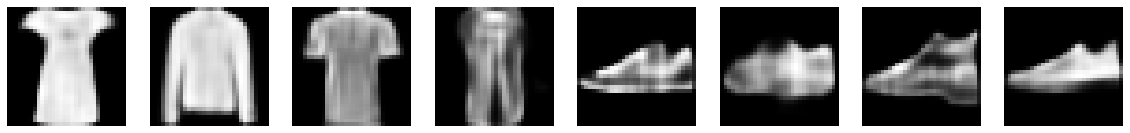

In [9]:
wgan = WGAN_GP(image_shape)
wgan.train(iter(ds_train), batch_size, 5000, 100)

In [12]:
wgan.model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
batch_normalization_3 (Batch (None, 8192)              32768     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 256)         3277

In [11]:
wgan.critic.summary()

Model: "critics"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 128)       3200      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)         819200    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 512)         3276800   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0   

In [10]:
wgan.generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
batch_normalization_3 (Batch (None, 8192)              32768     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 256)         10

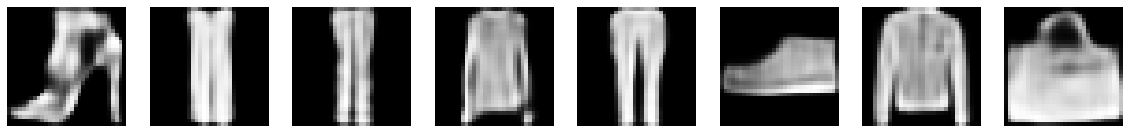

In [24]:
z = tf.random.normal((8, 128))
generated_images = wgan.generator.predict(z)
wgan.plot_images(generated_images)